In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection, LineCollection
import matplotlib.path as mpath
import matplotlib.lines as mlines
from matplotlib import gridspec

# Make fonts AI editable
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import numpy as np
import pandas as pd
import os
os.chdir("/users/dten0001/Google Drive/baltic3/examples/")
import sys
from functools import reduce
import subprocess

seg_ls = ["HA", "MP", "NA", "NP", "NS", "PA", "PB1", "PB2"]

import xio
import my_utils as xu
import baltic3 as bt
import baltic3_utils as btu

from Bio import Phylo


def lookup_meta_value(tip_name, dm, dm_colname, colname, verbose=True):
    """Looks up the metadata value of a given tip_name.
    Currently only accepts one colname; not a list.
    """
    val = "*"
    d_temp = dm.loc[dm[dm_colname]==tip_name]
    if len(d_temp) > 1:
        if verbose:
            print("WARNING: Multiple entries found for %s!" % tip_name)
    elif len(d_temp) == 0:
        if verbose:
            print("WARNING: No entries found for %s!" % tip_name)
    elif len(d_temp) == 1:
        val = d_temp[colname].values[0]
        
    return val

# Tree with Heatmap

In this example, the different segments of a set of H5Nx sequences, where x = {1, 2, 5, 6, 8}, have been allocated different clade labels in order to reflect reassortment betweeen clades. Note that the clade labels are actually not accurate, but the correctness of the data isn't important for the purposes of this tutorial.

In this figure:

 - The tree is a HA H5 tree
 - The tip shapes are coloured by the subtype of the Nx segment, where x = {1, 2, 5, 6, 8}
 - The clade labels of the rest of the segments are represented by heatmaps
 
I've also put in guidelines showing the architecture behind the plot, in the "show guidelines" commentated section at the very bottom of the plotting cell.

### Input

 - A tree file, `sample_56_HA_mls.nex`
 - A metadata sheet of clade labels, `h5nx_segments.csv`

In [2]:
# Load tree
ha_tree = btu.austechia_read_tree("sample_56_HA_mls.nex", date_delim = "|")

# Load metadata
dm = pd.read_csv("h5nx_segments.csv")

# print out a list of all unique row values in the spreadsheet
# to create cdict
ls_of_ls = []
for seg in seg_ls:
    ls_of_ls.append(list(dm[seg]))
results_union = list(set().union(*ls_of_ls))
results_union.sort()
for ln in results_union:
    print(ln)


Number of objects found in tree string: 111

Tree height: 0.104143
Tree length: 0.491204
strictly bifurcating tree

Numbers of objects in tree: 111 (55 nodes and 56 leaves)

Highest tip date: 2017.0110
2.3
EA-avian
H5N1-2.3.2.1
HK97-like
NA-avian


In [3]:
# Plot params
branchWidth=1.0
tip_size = 60
my_cols = seg_ls

# clade colour dictionary
c_dict = {"EA-avian": "#2F8B6F", 
         "NA-avian": "#365D8A", 
         "2.3": "#D39C47", 
         "H5N1": "#D39C47",
         "H5N1-2.3.2.1": "#D37847"}

# For the legend, to spell out all row values in full
disp_cdict = {"EA-avian": "Eurasian Avian", 
         "NA-avian": "North American Avian", 
         "2.3": "H5N1", 
         "H5N1": "H5N1",
         "H5N1-2.3.2.1": "H5N1-2.3.2.1"}

# a colour dictionary
strain_cdict = {"H5N1": "grey",
                 "H5N8": "green",
                 "H5N6": "red",
                 "H5N2": "blue",
                 "H5N5": "orange"}


# TRACK PARAMS
track_x = ha_tree.treeHeight * 1.07 # distance from the left edge of the leftmost track to the tree. 
track_width = ha_tree.treeHeight * 0.1 # width of each track
track_height_factor = 1.25 # track_height = branchWidth * track_height_factor
track_label_y = 0.5 # distance between the bottom of the track and the labels. 
# Why isn't track_label_y automatic?
track_fontsize = 8

# LEGEND PARAMS
legend_x = 0 # x-position of both colour legends
legend_y = 55 # top-most y position of the internal gene colour legend
i_multiplier = 2 # multiplies the distance between each legend bar
legend_y2 = 46 # top-most y position of the Nx legend
legend_w = track_width*0.5 # width of legend

# TEXT PARAMS
title_size = 20
title_y_pos = 58.5
segment_title_y_pos = 57
segment_subtitle_size = 14
legend_text_size = 12

# Some computations to do with the y-coordinates in the tree
leaf_ycoord_max = 0
leaf_ycoord_min = len(ha_tree.leaves)
for lf in ha_tree.leaves:
    if lf.y > leaf_ycoord_max:
        leaf_ycoord_max = lf.y
    elif lf.y < leaf_ycoord_min:
        leaf_ycoord_min = lf.y

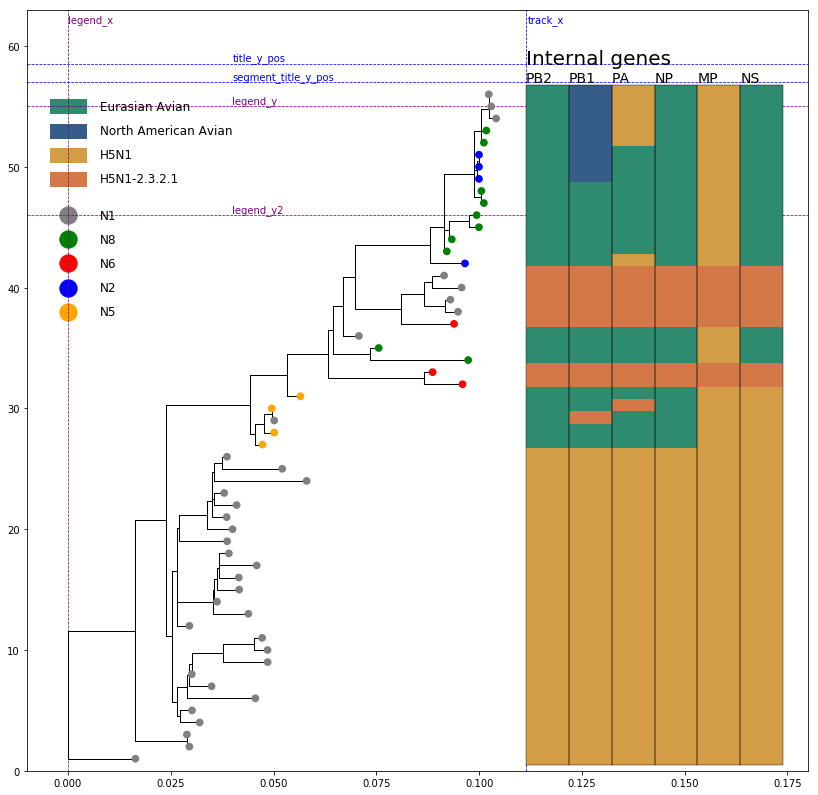

In [4]:
fig,ax = plt.subplots(figsize=(14,14),facecolor='w')

seg_ls3 = ["PB2", "PB1", "PA", "NP", "MP", "NS"]

# ==================== Tree ====================
for k in ha_tree.Objects:
    c = 'k'
    x=k.height # raw (x, y) coords
    y=k.y

    xp = k.parent.height
    if x is None: # matplotlib won't plot Nones, like root
        x = 0
    if xp==None:
        xp = x

    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        # Label tip shapes with subtype, except H1N1
        lf_strain = k.name.split("|")[0]
        my_colour = strain_cdict[lf_strain]
        ax.scatter(x,y,s=tip_size,facecolor=my_colour,edgecolor='none',zorder=11)
        
        # ==================== Draw tracks ====================
        # segment by segment. Only internal genes (seg_ls3)
        
        for i in range(len(seg_ls3)):
            seg = seg_ls3[i]
            lookup_col = seg
            val = lookup_meta_value(k.name, dm, "header", lookup_col, verbose=False)
            if val == "*": # WARNING: Overriding a default-return error value. 
                val = "H5N1"
            c = c_dict[val]
            
            rect = patches.Rectangle((track_x+(i*track_width),y-0.5), #(x,y)-coords
                                     track_width, # width
                                     branchWidth*track_height_factor, # height
                                     linewidth=0,
                                     edgecolor="white",
                                     facecolor=c,
                                     zorder=9)
            ax.add_patch(rect)

    elif isinstance(k,bt.node) or k.branchType=='node':
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],
                lw=branchWidth,
                color='k',
                ls='-',
                zorder=9)
    ax.plot([xp,x],[y,y],lw=branchWidth,color='k',ls='-',zorder=9)
    
    
# ==================== track borders and labels ====================
tree_v_height = leaf_ycoord_max - leaf_ycoord_min+1

n_tracks = len(ha_tree.Objects)
track_rect_ht = n_tracks
for i in range(len(seg_ls3)):
    # +0.5 so that the dotted lines point to the middle of each track rectangle
    rect = patches.Rectangle((track_x+(i*track_width), 0.5), #(x,y)-coords
                             track_width, tree_v_height+0.25, # width, height
                             linewidth=0.4,
                             edgecolor="k",
                             fill=False,
                             zorder=10)
    ax.add_patch(rect)

# ==================== segment titles ====================
ax.text(track_x, title_y_pos, "Internal genes", size=title_size)
for i in range(len(seg_ls3)):
    seg = seg_ls3[i]
    # Segment subtitles, i.e. "PB2", "PB1", etc...
    ax.text((track_x+(i*track_width)), segment_title_y_pos, 
            seg, 
            size=segment_subtitle_size)

# ==================== legend ====================
legend_labels_ls = ['EA-avian', 'NA-avian', 'H5N1', 'H5N1-2.3.2.1']

for i in range(len(legend_labels_ls)):
    legend_label = legend_labels_ls[i]
    ax.plot([legend_x-legend_w/2, legend_x+legend_w/2], 
            [legend_y-(i*i_multiplier), legend_y-(i*i_multiplier)], 
            lw=branchWidth*15, c=c_dict[legend_label])
    
    ax.text(legend_x+(legend_w*1.5), 
            legend_y-(i*i_multiplier), 
            disp_cdict[legend_label], 
            size=legend_text_size,
            verticalalignment="center")

legend_labels_ls = list(strain_cdict.keys()) # OVERRIDE!
for i in range(len(legend_labels_ls)):
    legend_label = legend_labels_ls[i]
    ax.scatter(legend_x,
               legend_y2-(i*i_multiplier),
               color=strain_cdict[legend_label], 
               s=300)

    ax.text(legend_x+(legend_w*1.5), 
            legend_y2-(i*i_multiplier), 
            legend_label[-2:], 
            size=legend_text_size, 
            verticalalignment="center")
    

# ==================== title text ====================
#ax.text(0, 50, "HA Tree\nClade 2.3.", size=45)



# ==================== Show guidelines ====================
ax.axhline(y=title_y_pos, ls="--", lw=0.75, c="blue")
ax.axhline(y=segment_title_y_pos, ls="--", lw=0.75, c="blue")
ax.text(0.04, title_y_pos*1.005, "title_y_pos", color="blue")
ax.text(0.04, segment_title_y_pos*1.005, "segment_title_y_pos", color="blue")

ax.axvline(x=track_x, ls="--", lw=0.75, c="blue")
ax.text(track_x*1.003, 62,"track_x", color="blue")

ax.axvline(x=legend_x, ls="--", lw=0.75, c="purple")
ax.axhline(y=legend_y, ls="--", lw=0.75, c="purple")
ax.axhline(y=legend_y2, ls="--", lw=0.75, c="purple")
ax.text(0.04, legend_y*1.005, "legend_y", color="purple")
ax.text(0.04, legend_y2*1.005, "legend_y2", color="purple")
ax.text(legend_x*1.005, 62, "legend_x", color="purple")

# X and Y limits have to be set explicitly
ax.set_xlim(-0.01,0.18)
ax.set_ylim(0, 63)
#plt.axis('off')
#plt.tight_layout()
plt.savefig("tutorial3_example_output.pdf", bbox="inches", pad_inches=0)
plt.show()
